In [3]:
import math, csv

f = open('trip_data_1.csv', 'r')
reader = csv.DictReader(f)

### Data Cleaning and Processing

- The incorrect data sources might store values incorrectly, expecially when working with raw GPS data, simulations, or conversions.
- If the data orginates from a different coordinate system(like UTM or Mercator), conversions might introduce large values.
- Operations like interpolation, transformations, or machine learning predictions might unintentionally generate out-of-bound values.

In [4]:
def normalize_latitude(lat):
    lat = float(lat)
    return (lat + 90) % 180 - 90 if lat < -90 or lat > 90 else lat

def normalize_longitude(lon):
    lon = float(lon)
    return (lon + 180) % 360 - 180 if lon < -180 or lon > 180 else lon

### What datetime range does your data cover?  How many rows are there total?

- It covers 3 datetime ranges those are pickup_datetime, dropoff_datetime, trip_time_in_secs in the year-month-day hh:mm:ss.

In [5]:
counter = 0
for row in reader:
    counter += 1

print(counter)

14776615


### What are the field names?  Give descriptions for each field.

- medallion: a permit that allows a person or business to operate a taxi in the city.
- hack_license: diver license
- vendor_id: A code indicating the TPEP provider that provided the record. It has two vendors CMT and VTS.
- rate_code: Rate category
- store_and_fwd_flag: This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.   Y= store and forward trip N= not a store and forward trip
- pickup_datetime: The date and time when the meter was engaged.
- dropoff_datetime: The date and time when the meter was disengaged.
- passenger_count: The number of passengers in the vehicle. This is a driver-entered value.
- trip_time_in_secs: The total time in seconds for passenger trip.
- trip_distance: The distance covered in the trip.
- pickup_longitude: Longitude where the meter was engaged.
- pickup_latitude: Latitude where the meter was engaged.
- dropoff_longitude: Longitude where the meter was disengaged.
- dropoff_latitude: Latitude where the meter was disengaged.

In [6]:
fieldnames = reader.fieldnames
print(fieldnames)

['medallion', 'hack_license', 'vendor_id', 'rate_code', 'store_and_fwd_flag', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'trip_time_in_secs', 'trip_distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']


### What MySQL data types / len would you need to store each of the fields?

- medallion: will take 32 character hexadecimal strings so `CHAR(32)` is ideal (fixed length means less overhead)
- hack_license: will tke 32 character hexadecimal strings so `CHAR(32)` is ideal.
- vendor_id: Since it contains CMT and VTS, a fixed length `CHAR(3)` works nicely.
- rate_code: small numeric field can be stored as TINY INT Unsigned.
- store_and_fwd_flag: One-character flag such as `N` or `Y` fits pefectly in `BOOLEAN`.
- pickup_datetime & dropoff_datetime: These fields include both date and time, so the `DATETIME` type is a natural fit.
- passenger_count: Typically a small number (1, 2, or 3), so `TINYINT UNSIGNED` is sufficient.
- trip_time_in_secs: This is mostly trip durations as modest, using `INT UNSIGNED` ensures you cover any long rides.
- trip_distance: With values like `2.10` or `9.50`, `DECIMAL(4,2)` allows up to 99.99 miles, which is ample for NYC trips.
- pickup_longitude & pickup_latitude & dropoff_longitude & dropoff_latitude: Using `DECIMAL(9,6)` provides a good balance between range and precision for latitude and longitude.


### Give some sample data for each field.

In [7]:
f = open('trip_data_1.csv', 'r')
reader = csv.DictReader(f)

counter = 10

for field in fieldnames:
    flag = 0
    for row in reader:
        print(field,row[field])
        flag += 1
        if flag == counter:
            print("================================")
            break

medallion 89D227B655E5C82AECF13C3F540D4CF4
medallion 0BD7C8F5BA12B88E0B67BED28BEA73D8
medallion 0BD7C8F5BA12B88E0B67BED28BEA73D8
medallion DFD2202EE08F7A8DC9A57B02ACB81FE2
medallion DFD2202EE08F7A8DC9A57B02ACB81FE2
medallion 20D9ECB2CA0767CF7A01564DF2844A3E
medallion 496644932DF3932605C22C7926FF0FE0
medallion 0B57B9633A2FECD3D3B1944AFC7471CF
medallion 2C0E91FF20A856C891483ED63589F982
medallion 2D4B95E2FA7B2E85118EC5CA4570FA58
hack_license 06918214E951FA0003D1CC54955C2AB0
hack_license 06918214E951FA0003D1CC54955C2AB0
hack_license E949C583ECF62C8F03FDCE1484954A08
hack_license 93C363DDF8ED9385D65FAD07CE3F5F07
hack_license 7CE849FEF67514F080AF80D990F7EF7F
hack_license 7CE849FEF67514F080AF80D990F7EF7F
hack_license 351BE7D984BE17DB2FA80A748E816472
hack_license 460C3F57DD9CB2265DB75B14CD70224D
hack_license 36773E80775F26CD1158EB5450A61C79
hack_license D2363240A9295EF570FC6069BC4F4C92
vendor_id CMT
vendor_id CMT
vendor_id CMT
vendor_id CMT
vendor_id CMT
vendor_id CMT
vendor_id CMT
vendor_id CM

### What is the geographic range of your data (min/max - X/Y)?

In [8]:
f = open('trip_data_1.csv', 'r')
reader = csv.DictReader(f)

def valid_coordinate(lat, lon):
    if lat == 0 or lon == 0:
        return False
    if not (-90 <= lat <= 90):
        return False
    if not (-180 <= lon <= 180):
        return False
    return True


all_lats = []
all_lons = []

for row in reader:
    try:
        p_lat = normalize_latitude(row['pickup_latitude'])
        p_lon = normalize_longitude(row['pickup_longitude'])
        d_lat = normalize_latitude(row['dropoff_latitude'])
        d_lon = normalize_longitude(row['dropoff_longitude'])
    except ValueError:
        continue 

    if valid_coordinate(p_lat, p_lon):
        all_lats.append(p_lat)
        all_lons.append(p_lon)
    if valid_coordinate(d_lat, d_lon):
        all_lats.append(d_lat)
        all_lons.append(d_lon)

if not all_lats or not all_lons:
    raise ValueError("No valid coordinates found.")


all_lats.sort()
all_lons.sort()

if len(all_lats) >= 100:
    lower_idx_lat = int(len(all_lats) * 0.01)
    upper_idx_lat = int(len(all_lats) * 0.99) - 1
    min_lat = all_lats[lower_idx_lat]
    max_lat = all_lats[upper_idx_lat]
else:
    min_lat = all_lats[0]
    max_lat = all_lats[-1]

if len(all_lons) >= 100:
    lower_idx_lon = int(len(all_lons) * 0.01)
    upper_idx_lon = int(len(all_lons) * 0.99) - 1
    min_lon = all_lons[lower_idx_lon]
    max_lon = all_lons[upper_idx_lon]
else:
    min_lon = all_lons[0]
    max_lon = all_lons[-1]

print("Computed boundaries:")
print(f"Latitude:  {min_lat} to {max_lat}")
print(f"Longitude: {min_lon} to {max_lon}")

center_lat = (min_lat + max_lat) / 2
center_lon = (min_lon + max_lon) / 2


bounds = [[min_lat, min_lon], [max_lat, max_lon]]

print(f'South West Corner: {min_lat}, {min_lon}')
print(f'South East Corner: {min_lat}, {max_lon}')
print(f'North West Corner: {max_lat}, {min_lon}')
print(f'North East Corner: {max_lat}, {max_lon}')

Computed boundaries:
Latitude:  40.645866 to 40.814453
Longitude: -74.014481 to -73.789703
South West Corner: 40.645866, -74.014481
South East Corner: 40.645866, -73.789703
North West Corner: 40.814453, -74.014481
North East Corner: 40.814453, -73.789703


### Create a new CSV file which has only one out of every thousand rows.

In [9]:
f = open('trip_data_1.csv', 'r')
reader = csv.DictReader(f)

with open('trip_data_2.csv', 'w', newline='') as outfile:
    writer = csv.DictWriter(outfile, fieldnames=fieldnames)
    writer.writeheader()

    counter = 0
    for row in reader:
        if counter%1000 == 0:
            writer.writerow(row)
        counter += 1

### What is the average overall computed trip distance? (You should use Haversine Distance)

In [10]:
def haversine_distance(lat1, lon1, lat2, lon2, unit='miles'):
    lat1_rad, lon1_rad, lat2_rad, lon2_rad = map(math.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    if unit == 'miles':
        radius = 3959
    elif unit == 'km':
        radius = 6371
    else:
        raise ValueError("Unit must be 'miles' or 'km'.")

    return radius * c

total_distance = 0.0
trip_count = 0
trip_distances = []


max_valid_distance = 100  # miles

f = open('trip_data_1.csv', 'r')
reader = csv.DictReader(f)

for row in reader:
    try:
        p_lat = normalize_latitude(row['pickup_latitude'])
        p_lon = normalize_longitude(row['pickup_longitude'])
        d_lat = normalize_latitude(row['dropoff_latitude'])
        d_lon = normalize_longitude(row['dropoff_longitude'])
    except ValueError:
        continue

    if not (valid_coordinate(p_lat, p_lon) and valid_coordinate(d_lat, d_lon)):
        continue

    distance = haversine_distance(p_lat, p_lon, d_lat, d_lon, unit='miles')

    if 0 < distance < 100:
        trip_distances.append(distance)

    if distance > max_valid_distance:
        continue

    total_distance += distance
    trip_count += 1

if trip_count > 0:
    average_distance = total_distance / trip_count
    print(f"Total valid trips: {trip_count}")
    print(f"Total computed distance: {total_distance:.2f} miles")
    print(f"Average trip distance: {average_distance:.2f} miles")
else:
    print("No valid trips found.")

Total valid trips: 14488493
Total computed distance: 29189875.26 miles
Average trip distance: 2.01 miles


### Draw a histogram of the trip distances binned anyway you see fit.

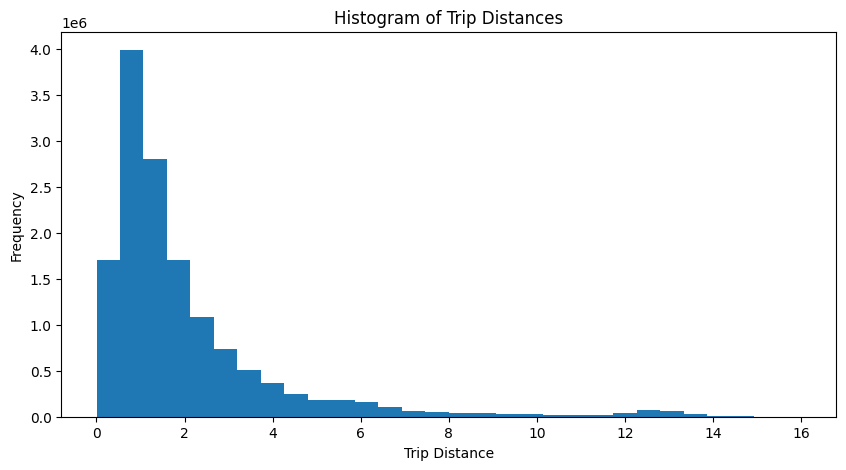

In [11]:
import matplotlib.pyplot as plt

trip_distances_limited = [d for d in trip_distances if d <= 16]

plt.figure(figsize=(10,5))
plt.hist(trip_distances_limited, bins=30)
plt.xlabel('Trip Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Trip Distances')

plt.show()

### What are the distinct values for each field?

In [12]:
def distinctValues(filename, fieldname, num_samples = counter):
    distinct_vals = set()
    try:
        with open(filename, 'r') as file:
            reader = csv.DictReader(file)
            for i, row in enumerate(reader):
                if i >= num_samples:
                    break
                if fieldname in row:
                    distinct_vals.add(row[fieldname])
    except FileNotFoundError:
        print(f"Error: File '{filename}' not found.")
        return set()
    return distinct_vals

filename = 'trip_data_1.csv'
for fieldname in ['vendor_id', 'rate_code', 'store_and_fwd_flag', 'passenger_count']:
    distinct_values_set = distinctValues(filename, fieldname)
    print(f"Distinct values for '{fieldname}': {distinct_values_set}")

Distinct values for 'vendor_id': {'CMT', 'VTS'}
Distinct values for 'rate_code': {'4', '5', '9', '1', '2', '128', '8', '3', '7', '0', '28', '6', '65', '210'}
Distinct values for 'store_and_fwd_flag': {'', 'Y', 'N'}
Distinct values for 'passenger_count': {'4', '5', '255', '9', '1', '2', '3', '0', '6', '208'}


### For other numeric types besides lat and lon, what are the min and max values?

In [13]:
def analyze_numeric_fields(filename, fields_to_analyze):
    min_max_values = {field: {'min': float('inf'), 'max': float('-inf')} for field in fields_to_analyze}

    try:
        with open(filename, 'r', newline='', encoding='utf-8') as file:
            reader = csv.DictReader(file)
            rows_processed = 0

            for row in reader:
                rows_processed += 1
                for field in fields_to_analyze:
                    try:
                        if field in row and row[field].strip():
                            value = float(row[field])
                            min_max_values[field]['min'] = min(min_max_values[field]['min'], value)
                            min_max_values[field]['max'] = max(min_max_values[field]['max'], value)
                    except ValueError as e:
                        print(e)
        
        for field in min_max_values:
            if min_max_values[field]['min'] == float('inf'):
                min_max_values[field]['min'] = None
            if min_max_values[field]['max'] == float('-inf'):
                min_max_values[field]['max'] = None
    
    except FileNotFoundError as e:
        print(e)
        return None
    
    return min_max_values

filename = 'trip_data_1.csv'
fields = ['passenger_count', 'trip_time_in_secs', 'trip_distance']
results = analyze_numeric_fields(filename, fields)

if results:
    for field, min_max in results.items():
        print(f"Field: {field}")
        print(f"  Min: {min_max['min']}")
        print(f"  Max: {min_max['max']}")

Field: passenger_count
  Min: 0.0
  Max: 255.0
Field: trip_time_in_secs
  Min: 0.0
  Max: 10800.0
Field: trip_distance
  Min: 0.0
  Max: 100.0


### Create a chart which shows the average number of passengers each hour of the day. (X axis should have 24 hours

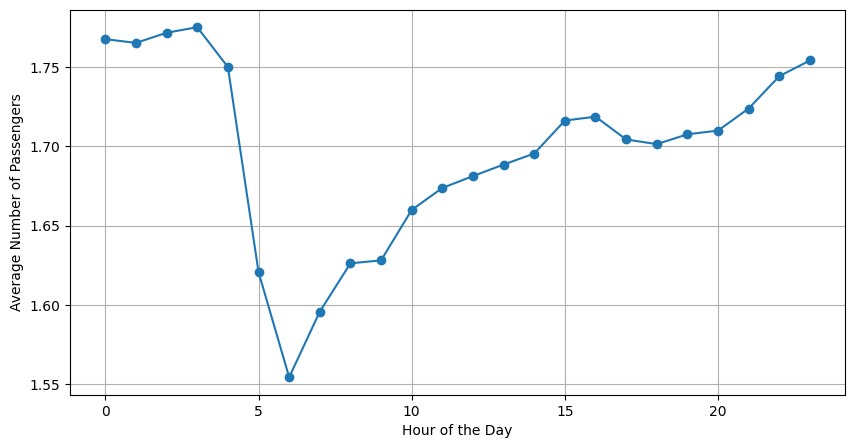

In [14]:
from collections import defaultdict
import datetime

def analyze_passengers_by_hour(filename):
    hourly_passengers = defaultdict(list)
    try:
        with open(filename, 'r', newline='', encoding='utf-8') as file:
            reader = csv.DictReader(file)
            
            for row in reader:
                try:
                    pickup_time = datetime.datetime.strptime(row['pickup_datetime'], "%Y-%m-%d %H:%M:%S")
                    hour = pickup_time.hour
                    passengers = int(row['passenger_count'])
                    hourly_passengers[hour].append(passengers)
                except (ValueError, KeyError) as e:
                    print(e)
                    continue
        
        hourly_avg_passengers = {hour: sum(values)/len(values) for hour, values in hourly_passengers.items()}
        return hourly_avg_passengers

    except FileNotFoundError as e:
        print(e)
        return None

filename = 'trip_data_1.csv'
hourly_avg_passengers = analyze_passengers_by_hour(filename)
if hourly_avg_passengers:
    hours = sorted(hourly_avg_passengers.keys())
    averages = [hourly_avg_passengers[hour] for hour in hours]

    plt.figure(figsize=(10, 5))
    plt.plot(hours, averages, marker='o', linestyle='-')

    plt.xlabel('Hour of the Day')
    plt.ylabel('Average Number of Passengers')
    plt.grid(True)

    plt.show()

else:
    print("No data available to generate the chart.")

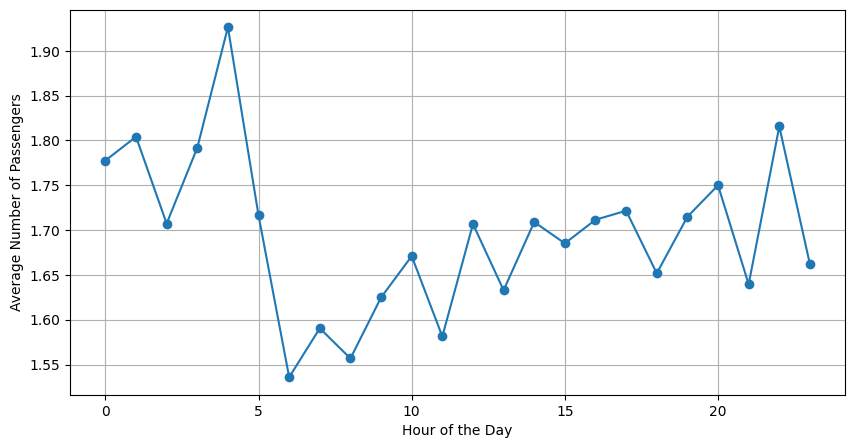

In [15]:
from collections import defaultdict
import datetime

def analyze_passengers_by_hour(filename):
    hourly_passengers = defaultdict(list)
    try:
        with open(filename, 'r', newline='', encoding='utf-8') as file:
            reader = csv.DictReader(file)
            
            for row in reader:
                try:
                    pickup_time = datetime.datetime.strptime(row['pickup_datetime'], "%Y-%m-%d %H:%M:%S")
                    hour = pickup_time.hour
                    passengers = int(row['passenger_count'])
                    hourly_passengers[hour].append(passengers)
                except (ValueError, KeyError) as e:
                    print(e)
                    continue
        
        hourly_avg_passengers = {hour: sum(values)/len(values) for hour, values in hourly_passengers.items()}
        return hourly_avg_passengers

    except FileNotFoundError as e:
        print(e)
        return None

filename = 'trip_data_2.csv'
hourly_avg_passengers = analyze_passengers_by_hour(filename)
if hourly_avg_passengers:
    hours = sorted(hourly_avg_passengers.keys())
    averages = [hourly_avg_passengers[hour] for hour in hours]

    plt.figure(figsize=(10, 5))
    plt.plot(hours, averages, marker='o', linestyle='-')

    plt.xlabel('Hour of the Day')
    plt.ylabel('Average Number of Passengers')
    plt.grid(True)

    plt.show()

else:
    print("No data available to generate the chart.")